In [2]:
!pip install Seaborn

In [1]:
# Importing Lib

import os
import glob
import numpy as np
import pandas as pd

# importing the Virtulization Lib
import seaborn as sns
import matplotlib.pyplot as plt

# Model Selection Lib
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Loading the Dataset
dataset_main = list(glob.glob('C:\\Users\Piyush Tyagi\OneDrive\Desktop\Python notebook\Weather Image Recignition data\dataset'+'/**/*.jpg'))

In [3]:
# Spliting the path for the subfolders

labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], dataset_main))

In [4]:
# Accessing the images in the sub folders

file_path = pd.Series(dataset_main, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,C:\Users\Piyush Tyagi\OneDrive\Desktop\Python ...,glaze
1,C:\Users\Piyush Tyagi\OneDrive\Desktop\Python ...,rime
2,C:\Users\Piyush Tyagi\OneDrive\Desktop\Python ...,dew
3,C:\Users\Piyush Tyagi\OneDrive\Desktop\Python ...,sandstorm
4,C:\Users\Piyush Tyagi\OneDrive\Desktop\Python ...,rime


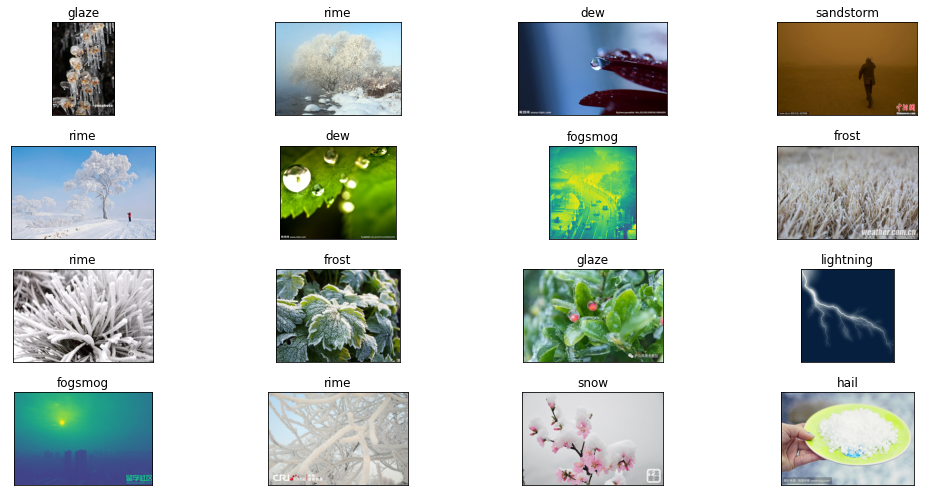

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

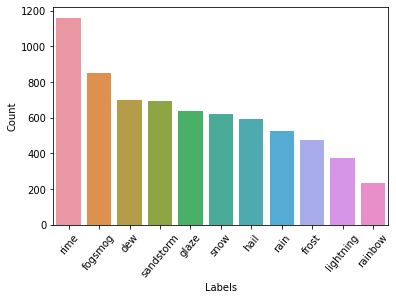

In [6]:
#ploting the images count for all type of weathers
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [7]:
# Spliting the data in train and test

train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [8]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [9]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [10]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [11]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
              precision    recall  f1-score   support

         dew       0.95      0.69      0.80       144
     fogsmog       0.65      0.73      0.69       157
       frost       0.43      0.74      0.54        81
       glaze       0.71      0.44      0.54       123
        hail       0.87      0.81      0.84       134
   lightning       0.96      0.76      0.85        67
        rain       0.89      0.72      0.79       102
     rainbow       0.93      0.80      0.86        49
        rime       0.70      0.89      0.79       235
   sandstorm       0.70      0.81      0.75       144
        snow       0.72      0.58      0.64       137

    accuracy                           0.73      1373
   macro avg       0.77      0.72      0.74      1373
weighted avg       0.76      0.73      0.73      1373



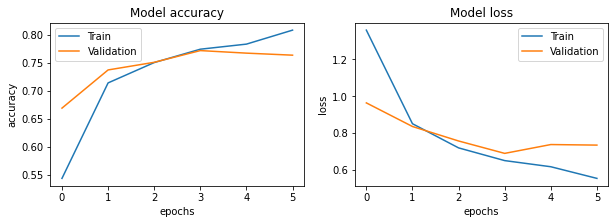

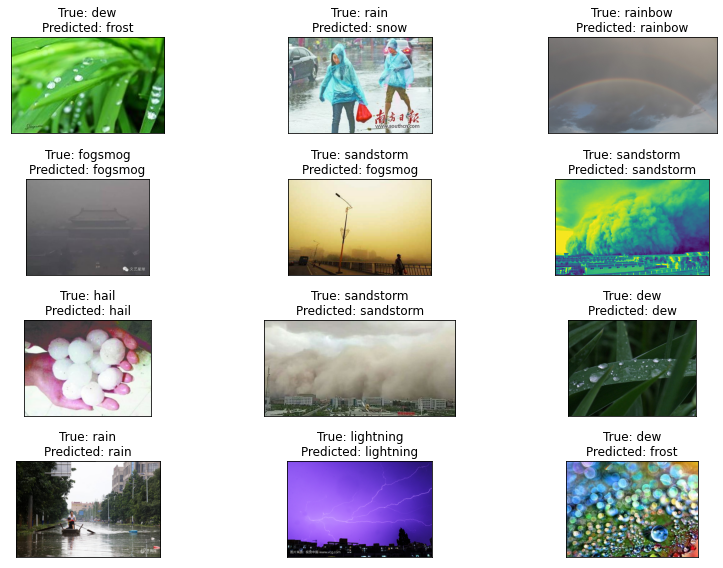

    Test Loss: 0.75693
Test Accuracy: 73.27%


In [12]:
# Traning the data
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)

result_ENet = result_test(test_gen_ENet,ENet_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
17235968/17225924 [==============================] - 1s 0us/step
              precision    recall  f1-score   support

         dew       0.87      0.81      0.84       144
     fogsmog       0.81      0.85      0.83       157
       frost       0.57      0.69      0.63        81
       glaze       0.69      0.70      0.69       123
        hail       0.91      0.86      0.88       134
   lightning       0.95      0.93      0.94        67
        rain       0.91      0.69      0.78       102
     rainbow       1.00      0.92      0.96        49
        rime       0.85      0.78      0.81       235
   sandstorm       0.87      0.83      0.85       144
        snow       0.55      0.74      0.63       137

    accuracy                           0.79      1373
   macro avg       0.82      0.80      0.80  

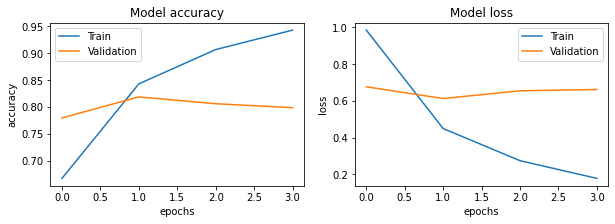

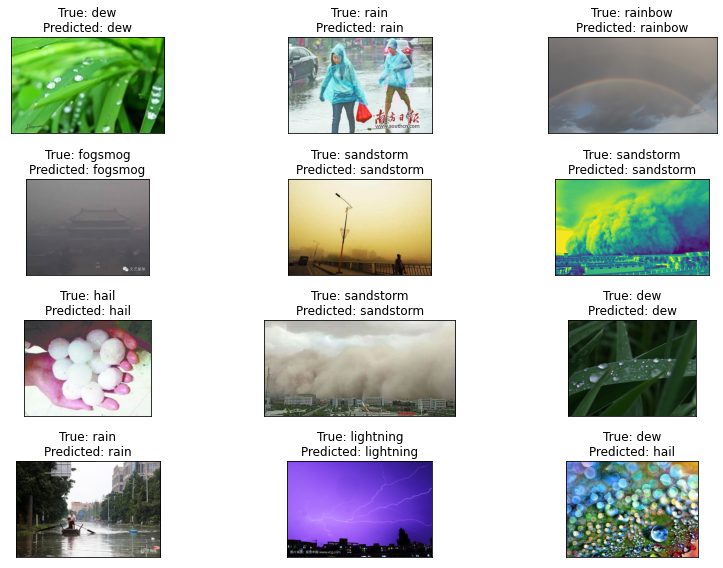

    Test Loss: 0.71819
Test Accuracy: 79.24%


In [13]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
80150528/80134624 [==============================] - 4s 0us/step
              precision    recall  f1-score   support

         dew       0.87      0.92      0.89       144
     fogsmog       0.77      0.90      0.83       157
       frost       0.65      0.65      0.65        81
       glaze       0.58      0.63      0.60       123
        hail       0.83      0.85      0.84       134
   lightning       0.95      0.90      0.92        67
        rain       0.81      0.69      0.74       102
     rainbow       0.86      0.86      0.86        49
        rime       0.76      0.79      0.78       235
   sandstorm       0.96      0.85      0.90       144
        snow       0.74      0.64      0.69       137

    accuracy                           0.79      1373
   macro avg       0.80      0.79      0.79  

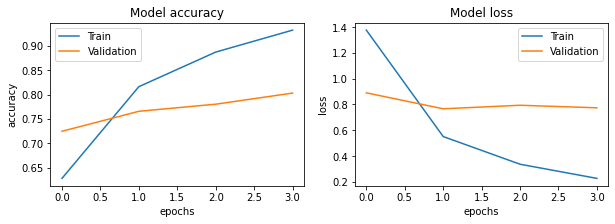

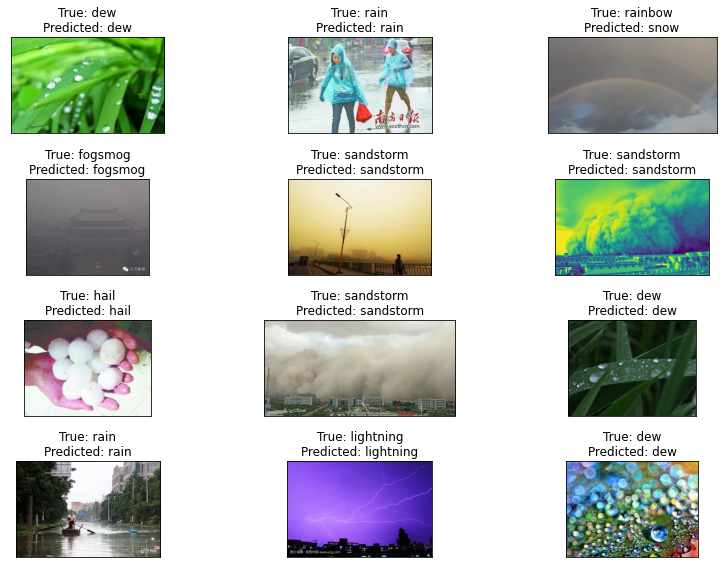

    Test Loss: 0.75115
Test Accuracy: 79.02%


In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = gen(VGG19_pre,train_df,test_df)
VGG19_model, callback=func(VGG19)
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
74850304/74836368 [==============================] - 3s 0us/step
              precision    recall  f1-score   support

         dew       0.95      0.90      0.93       144
     fogsmog       0.82      0.96      0.89       157
       frost       0.75      0.63      0.68        81
       glaze       0.75      0.72      0.73       123
        hail       0.91      0.87      0.89       134
   lightning       0.95      0.94      0.95        67
        rain       0.92      0.75      0.83       102
     rainbow       0.96      0.96      0.96        49
        rime       0.75      0.95      0.84       235
   sandstorm       0.96      0.86      0.91       144
        snow       0.76      0.64      0.70       137

    accuracy                           0.84      1373
   macro avg       0.86      0.83      0.85  

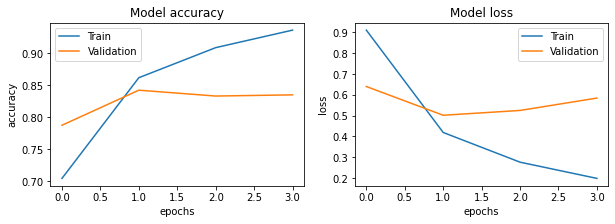

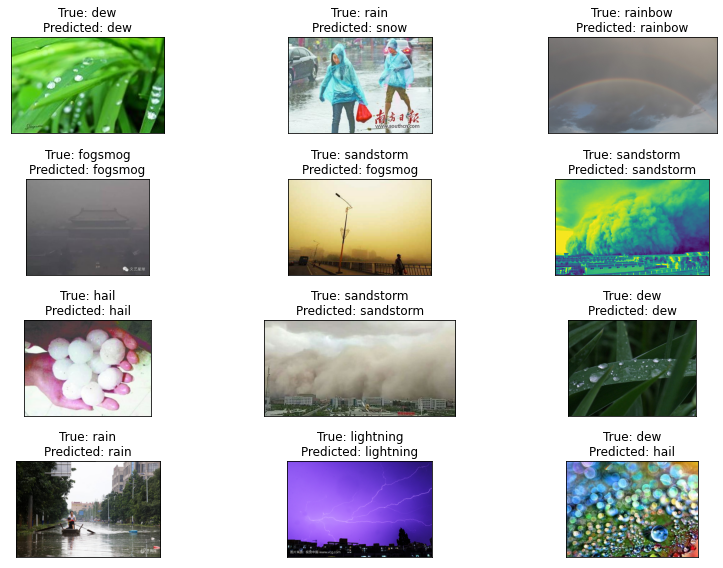

    Test Loss: 0.52506
Test Accuracy: 84.34%


In [15]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=func(DenseNet201)
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

In [27]:
output = pd.DataFrame({'Model':['MobileNet','VGG19',
                               'DenseNet201'],
                      'Accuracy':[result_MobileNet[1], result_VGG19[1],result_DenseNet201[1]]})

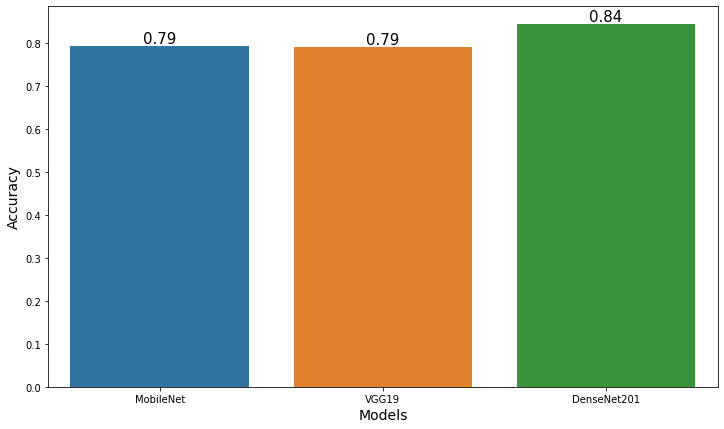

In [28]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()
